# ***importing libs***

In [58]:
import pathlib 
import numpy as np
import pandas as pd 
import os
import io

import tensorflow as tf 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy


import warnings
warnings.filterwarnings('ignore')

# ***Importing data and some desc stats***

In [59]:
df=pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", error_bad_lines=False, encoding='iso-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [60]:
df.shape

(5572, 5)

In [61]:
print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

# ***99 % of missing values in last 3 cols we are gonna drop them***

In [62]:
dataset=df.loc[:,'v1':'v2']
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# ***Preprocessing ***

In [63]:
dataset['target'] = dataset['v1'].apply(lambda x: 0 if x == 'ham' else 1)
dataset=dataset.iloc[:,1:]
dataset.head(2)

,v2,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0


In [64]:
!python -m spacy download en_core_web_md -q

2023-06-07 07:46:10.308104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# ***English packages***

In [65]:
import en_core_web_sm
nlp = en_core_web_sm.load()

# ***Stop words***

In [66]:
from spacy.lang.en.stop_words import STOP_WORDS

# ***remove no no numeric and no alphabetic charchters and white space ***

In [67]:
dataset["text_clean"] = dataset['v2'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# ***double space***

In [68]:
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# ***stop words removing and replacing with lemma***

In [69]:
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [70]:
dataset.head()

,v2,target,text_clean
0,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live


# ***we tokenize***

In [71]:
#if the words unkown we replace it with unknown
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="UNKNOWN") 
tokenizer.fit_on_texts(dataset['text_clean'])
dataset['text_clean_encoded'] = tokenizer.texts_to_sequences(dataset['text_clean'])

In [72]:
dataset.head()

,v2,target,text_clean,text_clean_encoded
0,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[3602, 230, 447, 463, 942, 36, 52, 204, 943, 7..."
1,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[10, 195, 464, 289, 2, 1453]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 299, 4, 533, 664, 34, 1454, 851, 423, 145..."
3,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[2, 125, 150, 2354, 2, 85]"
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live,"[709, 23, 665, 129]"


In [73]:
data_padding= tf.keras.preprocessing.sequence.pad_sequences(dataset['text_clean_encoded'], padding="post")

# ***test train split***

In [74]:
xtrain, xval, ytrain, yval = train_test_split(data_padding,dataset['target'], test_size=0.33)

# ***Les tensors***

In [75]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

# ***Les batchs***

In [76]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [77]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, BatchNormalization, GlobalAveragePooling1D

vocab_size = tokenizer.num_words
embedding_dim = 128

model = Sequential([         
                  Embedding(vocab_size+1, embedding_dim,name="embedding"), # Word embedding layer

                  GlobalAveragePooling1D(), #  pooling

                  Dense(64, activation='relu'), #fonction d'activation relu

                  Dense(32, activation='relu'), #fonction d'activation relu

                  Dense(1, activation="sigmoid") #fonction d'activation sigmoid pour la dernier layer entre  0 et 1 pour predire 
])


In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280128   
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,290,497
Trainable params: 1,290,497
Non-trainable params: 0
____________________________________________

# ***optimizer Adam***

In [79]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [80]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
59/59 [==============================] - 3s 40ms/step - loss: 0.4315 - accuracy: 0.8671 - val_loss: 0.3581 - val_accuracy: 0.8635
Epoch 2/20
59/59 [==============================] - 2s 40ms/step - loss: 0.3272 - accuracy: 0.8671 - val_loss: 0.3044 - val_accuracy: 0.8635
Epoch 3/20
59/59 [==============================] - 2s 38ms/step - loss: 0.2133 - accuracy: 0.8979 - val_loss: 0.1596 - val_accuracy: 0.9603
Epoch 4/20
59/59 [==============================] - 2s 42ms/step - loss: 0.0852 - accuracy: 0.9804 - val_loss: 0.0798 - val_accuracy: 0.9755
Epoch 5/20
59/59 [==============================] - 2s 40ms/step - loss: 0.0322 - accuracy: 0.9909 - val_loss: 0.0856 - val_accuracy: 0.9761
Epoch 6/20
59/59 [==============================] - 3s 47ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0595 - val_accuracy: 0.9826
Epoch 7/20
59/59 [==============================] - 3s 51ms/step - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.0869 - val_accuracy: 0.9777
Epoch 8/20
59

# ***training graphe  par rapport loss fonction***

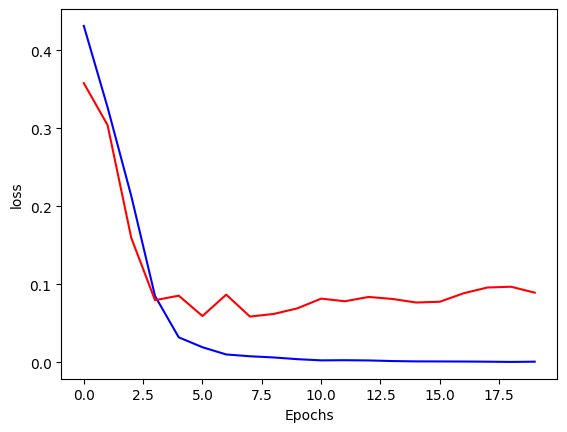

In [81]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

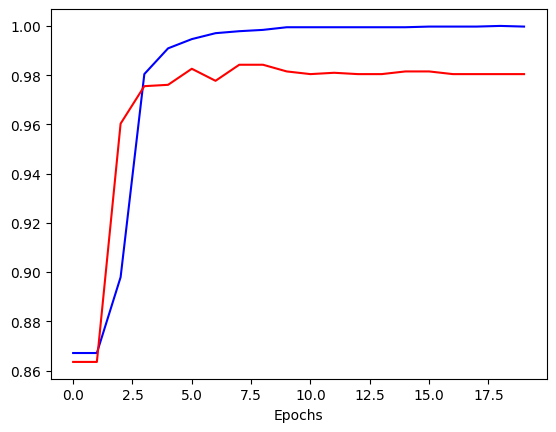

In [82]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("")
plt.xlabel("Epochs")
plt.show()

In [84]:
prediction = model.predict(xval)
classes_pred = [round(pred[0]) for pred in prediction]

print(classification_report(yval, classes_pred))
     

58/58 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1588
           1       0.99      0.86      0.92       251

    accuracy                           0.98      1839
   macro avg       0.98      0.93      0.96      1839
weighted avg       0.98      0.98      0.98      1839



In [87]:
type(yval)

pandas.core.series.Series

# ***our model has 93%  prediction for spam message ***